# Вариант 22

In [2]:
import sympy
import numpy as np
import control as ct
import control.matlab as ctm
import matplotlib.pyplot as plt

from IPython.display import display
from sympy import I

dt = 0.001

## Задание 1

рассмотрим $\ddot y + a_1 \dot y + a_0 y = u$

нейтральная и устойчивая апериодическая
пара устойчивых колебательных
пара неустойчивых колебательных

In [3]:
coeffs = [
    [0., 1.],
    [0.5, 1],
    [0.5, -1]
]
input_str = [
    '$u(t) = 1.5$',
    '$u(t) = 6t$',
    '$u(t) = cos(7t)$'
]

In [4]:
sec = 20
time = np.linspace(0, sec, int(sec/dt))
u = [
    np.ones_like(time)*1.5,
    time*0.6,
    np.cos(7*time)
]

In [5]:
init_states = [
    [-1, 0],
    [0, 0],
    [1, 0]
]

In [6]:
ss = [
    ct.tf2ss(
        [1.],
        [1., a[1], a[0]]
    ) for a in coeffs
]

In [7]:
y = {}

for i in range(len(ss)):
    inp_responses = {}
    for j in range(len(u)):
        inp_responses[f'input {j}'] =[
            ct.forced_response(
                ss[i],
                T=time,
                U=u[j],
                X0=state
            ) for state in init_states
        ]
    y[f'system {i}'] = inp_responses

In [8]:
from pprint import pprint

pprint(y)

{'system 0': {'input 0': [<control.timeresp.TimeResponseData object at 0x00000176D7C5DBA0>,
              'input 1': [<control.timeresp.TimeResponseData object at 0x00000176996FB670>,
              'input 2': [<control.timeresp.TimeResponseData object at 0x00000176996FAF50>,
                          <control.timeresp.TimeResponseData object at 0x00000176996FB760>]},
 'system 1': {'input 0': [<control.timeresp.TimeResponseData object at 0x00000176996FB8B0>,
              'input 1': [<control.timeresp.TimeResponseData object at 0x00000176996FB5B0>,
              'input 2': [<control.timeresp.TimeResponseData object at 0x00000176996FB970>,
                          <control.timeresp.TimeResponseData object at 0x00000176996FBA00>]},
 'system 2': {'input 0': [<control.timeresp.TimeResponseData object at 0x00000176996FB9D0>,
              'input 1': [<control.timeresp.TimeResponseData object at 0x00000176996FB520>,
              'input 2': [<control.timeresp.TimeResponseData object at 0x000

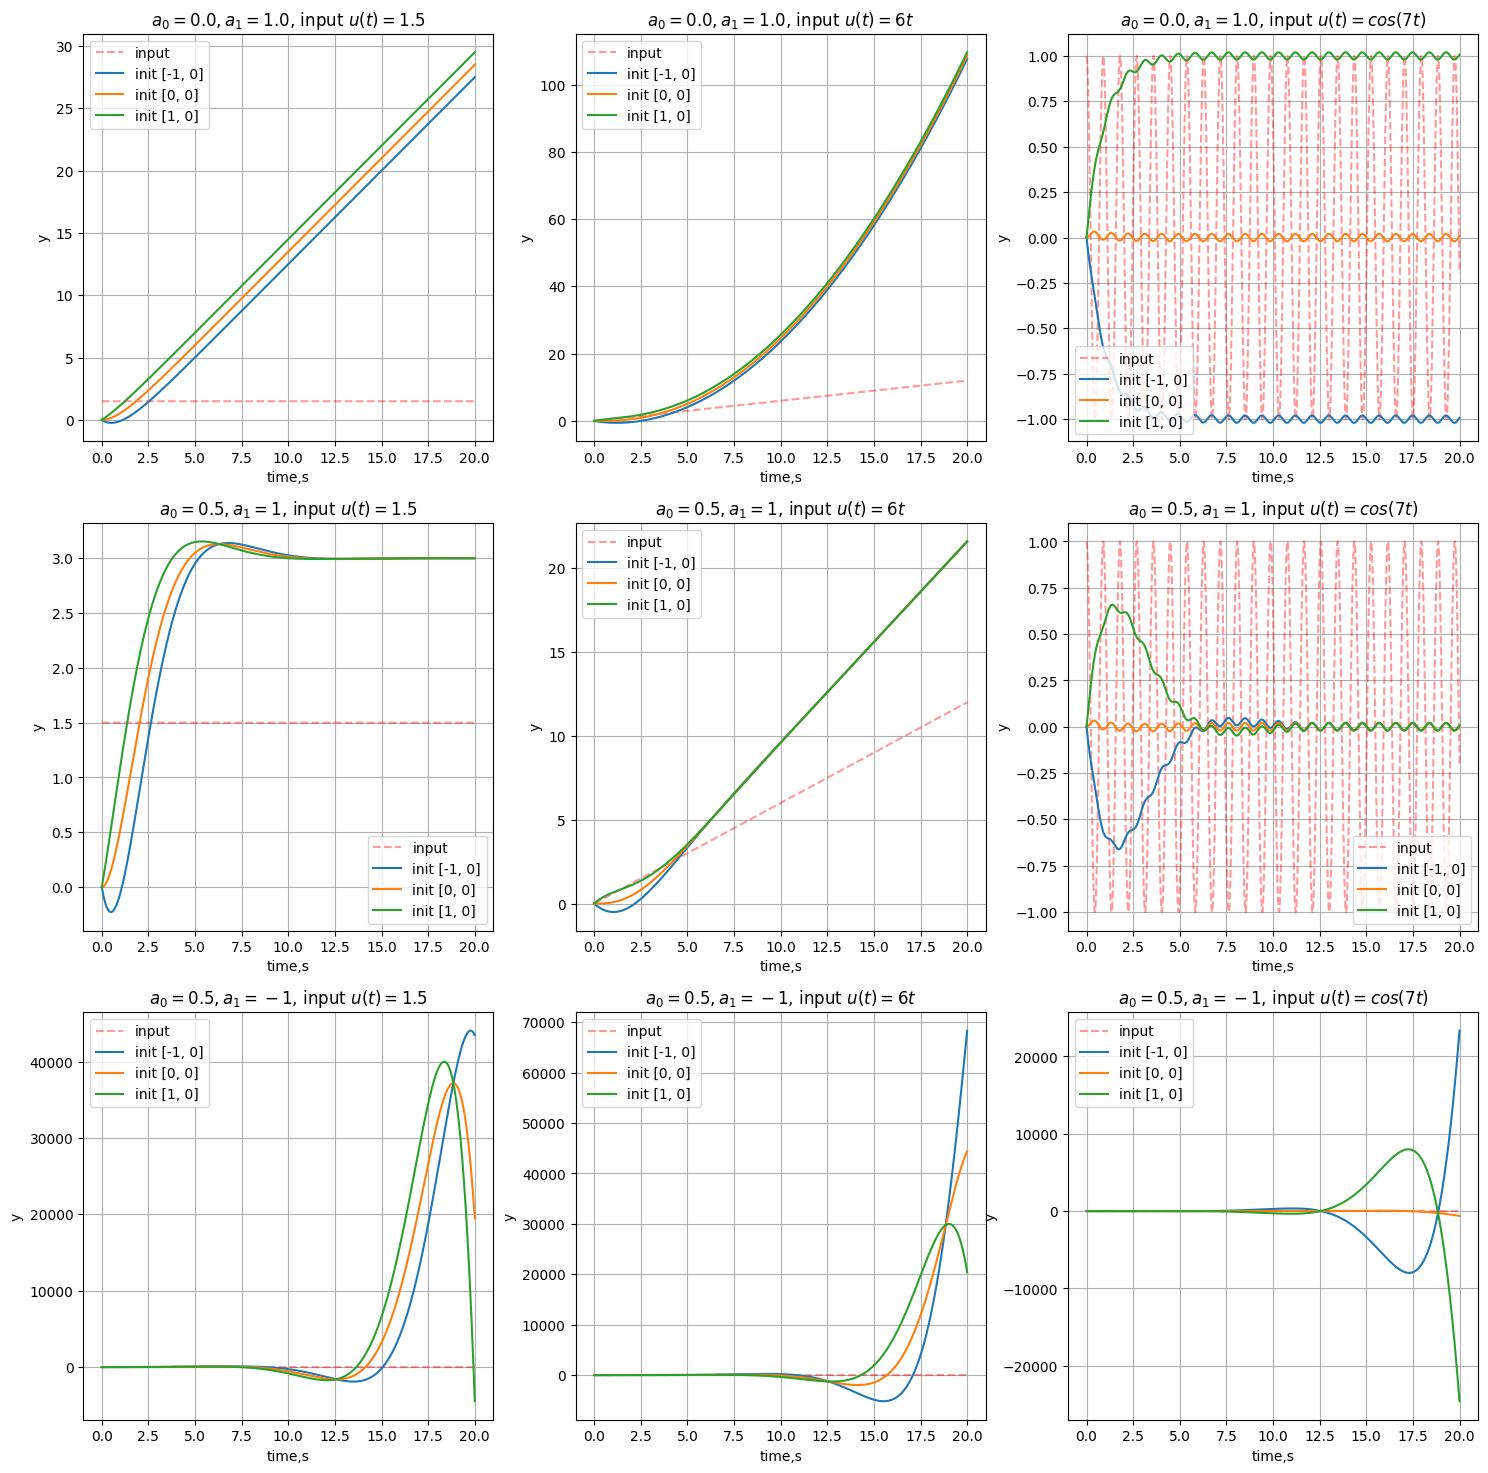

In [10]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize = (18, 18)
)

for i in range(len(y)):
    s = y[f'system {i}']
    
    for j in range(len(s)):    
        ax[i, j].set_title(f'$a_0 = {coeffs[i][0]}, a_1 = {coeffs[i][1]}$, input {input_str[j]}')
        ax[i, j].plot(time, u[j], "r--", alpha=0.4, label="input")
        ax[i, j].plot(time, s[f'input {j}'][0].outputs, label=f"init {init_states[0]}")
        ax[i, j].plot(time, s[f'input {j}'][1].outputs, label=f"init {init_states[1]}")
        ax[i, j].plot(time, s[f'input {j}'][2].outputs, label=f"init {init_states[2]}")
        
        ax[i,j].grid(True)
        ax[i,j].legend()
        ax[i,j].set_xlabel("time,s")
        ax[i,j].set_ylabel("y")

## Задание 2

In [11]:
s, l1, l2, l3 = sympy.symbols(r's lambda_0 lambda_1 lambda_2')

In [12]:
tf2 = 1 / ( (s - l1) * (s - l2) * (s - l3) )
sympy.Poly(sympy.fraction(tf2)[1], s)

Poly(s**3 + (-lambda_0 - lambda_1 - lambda_2)*s**2 + (lambda_0*lambda_1 + lambda_0*lambda_2 + lambda_1*lambda_2)*s - lambda_0*lambda_1*lambda_2, s, domain='ZZ[lambda_0,lambda_1,lambda_2]')

In [13]:
sec = 10
time = np.linspace(0, sec, int(sec/dt))
u = np.ones_like(time)
init_state2 = [1,1,0]

In [14]:
def get_ss_for_lambdas(lambdas):
    return ct.canonical_form(
        ct.tf2ss(
            [1.],
            [1, 
             -lambdas[0]-lambdas[1]-lambdas[2],
             lambdas[0]*lambdas[1] + lambdas[0]*lambdas[2] + lambdas[1]*lambdas[2],
             -lambdas[0]*lambdas[1]*lambdas[2]
             ],
        ),
        form='reachable'
    )[0]

In [15]:
roots = {
    'real':
        [
            [-1, -1.3, -1],
            [-2, -3, -4],
            [-10, -8, -3]
        ],
    'im_fixed_real':
        [
            [-1, -1 + 1j, -1 - 1j],
            [-1, -1 + 3j, -1 - 3j],
            [-1, -1 + 10j, -1 -10j]
        ],
    'real_im_fixed':
        [
            [-1, -1 + 2j, -1 - 2j],
            [-3, -3 + 2j, -3 - 2j],
            [-10, -10 + 2j, -10 - 2j]
        ]
}

In [16]:
systems = dict([
    (key, [get_ss_for_lambdas(lambdas) for lambdas in values])
    for key, values in roots.items()
])

C:\Users\obobojk\PycharmProjects\control_systems\venv\lib\site-packages\numpy\matrixlib\defmatrix.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return new.astype(intype)


In [17]:
def get_stability_degree(values):
    return min([abs(value.real) for value in values])

In [18]:
def get_oscillation_degree(values):
    return max([abs(complex(value)/value.real) for value in values])

In [19]:
def get_overregulation(outputs):
    return abs(outputs.max() - outputs[-1]) / abs(outputs[-1])*100

In [20]:
def get_stable_time(outputs, time):
    stable = outputs[-1]
    eps = 0.02*stable  
    for i in range(len(outputs)):
        if abs(outputs[-1-i]-stable) > eps:
            return time[-1-i], eps
    return time[0], eps

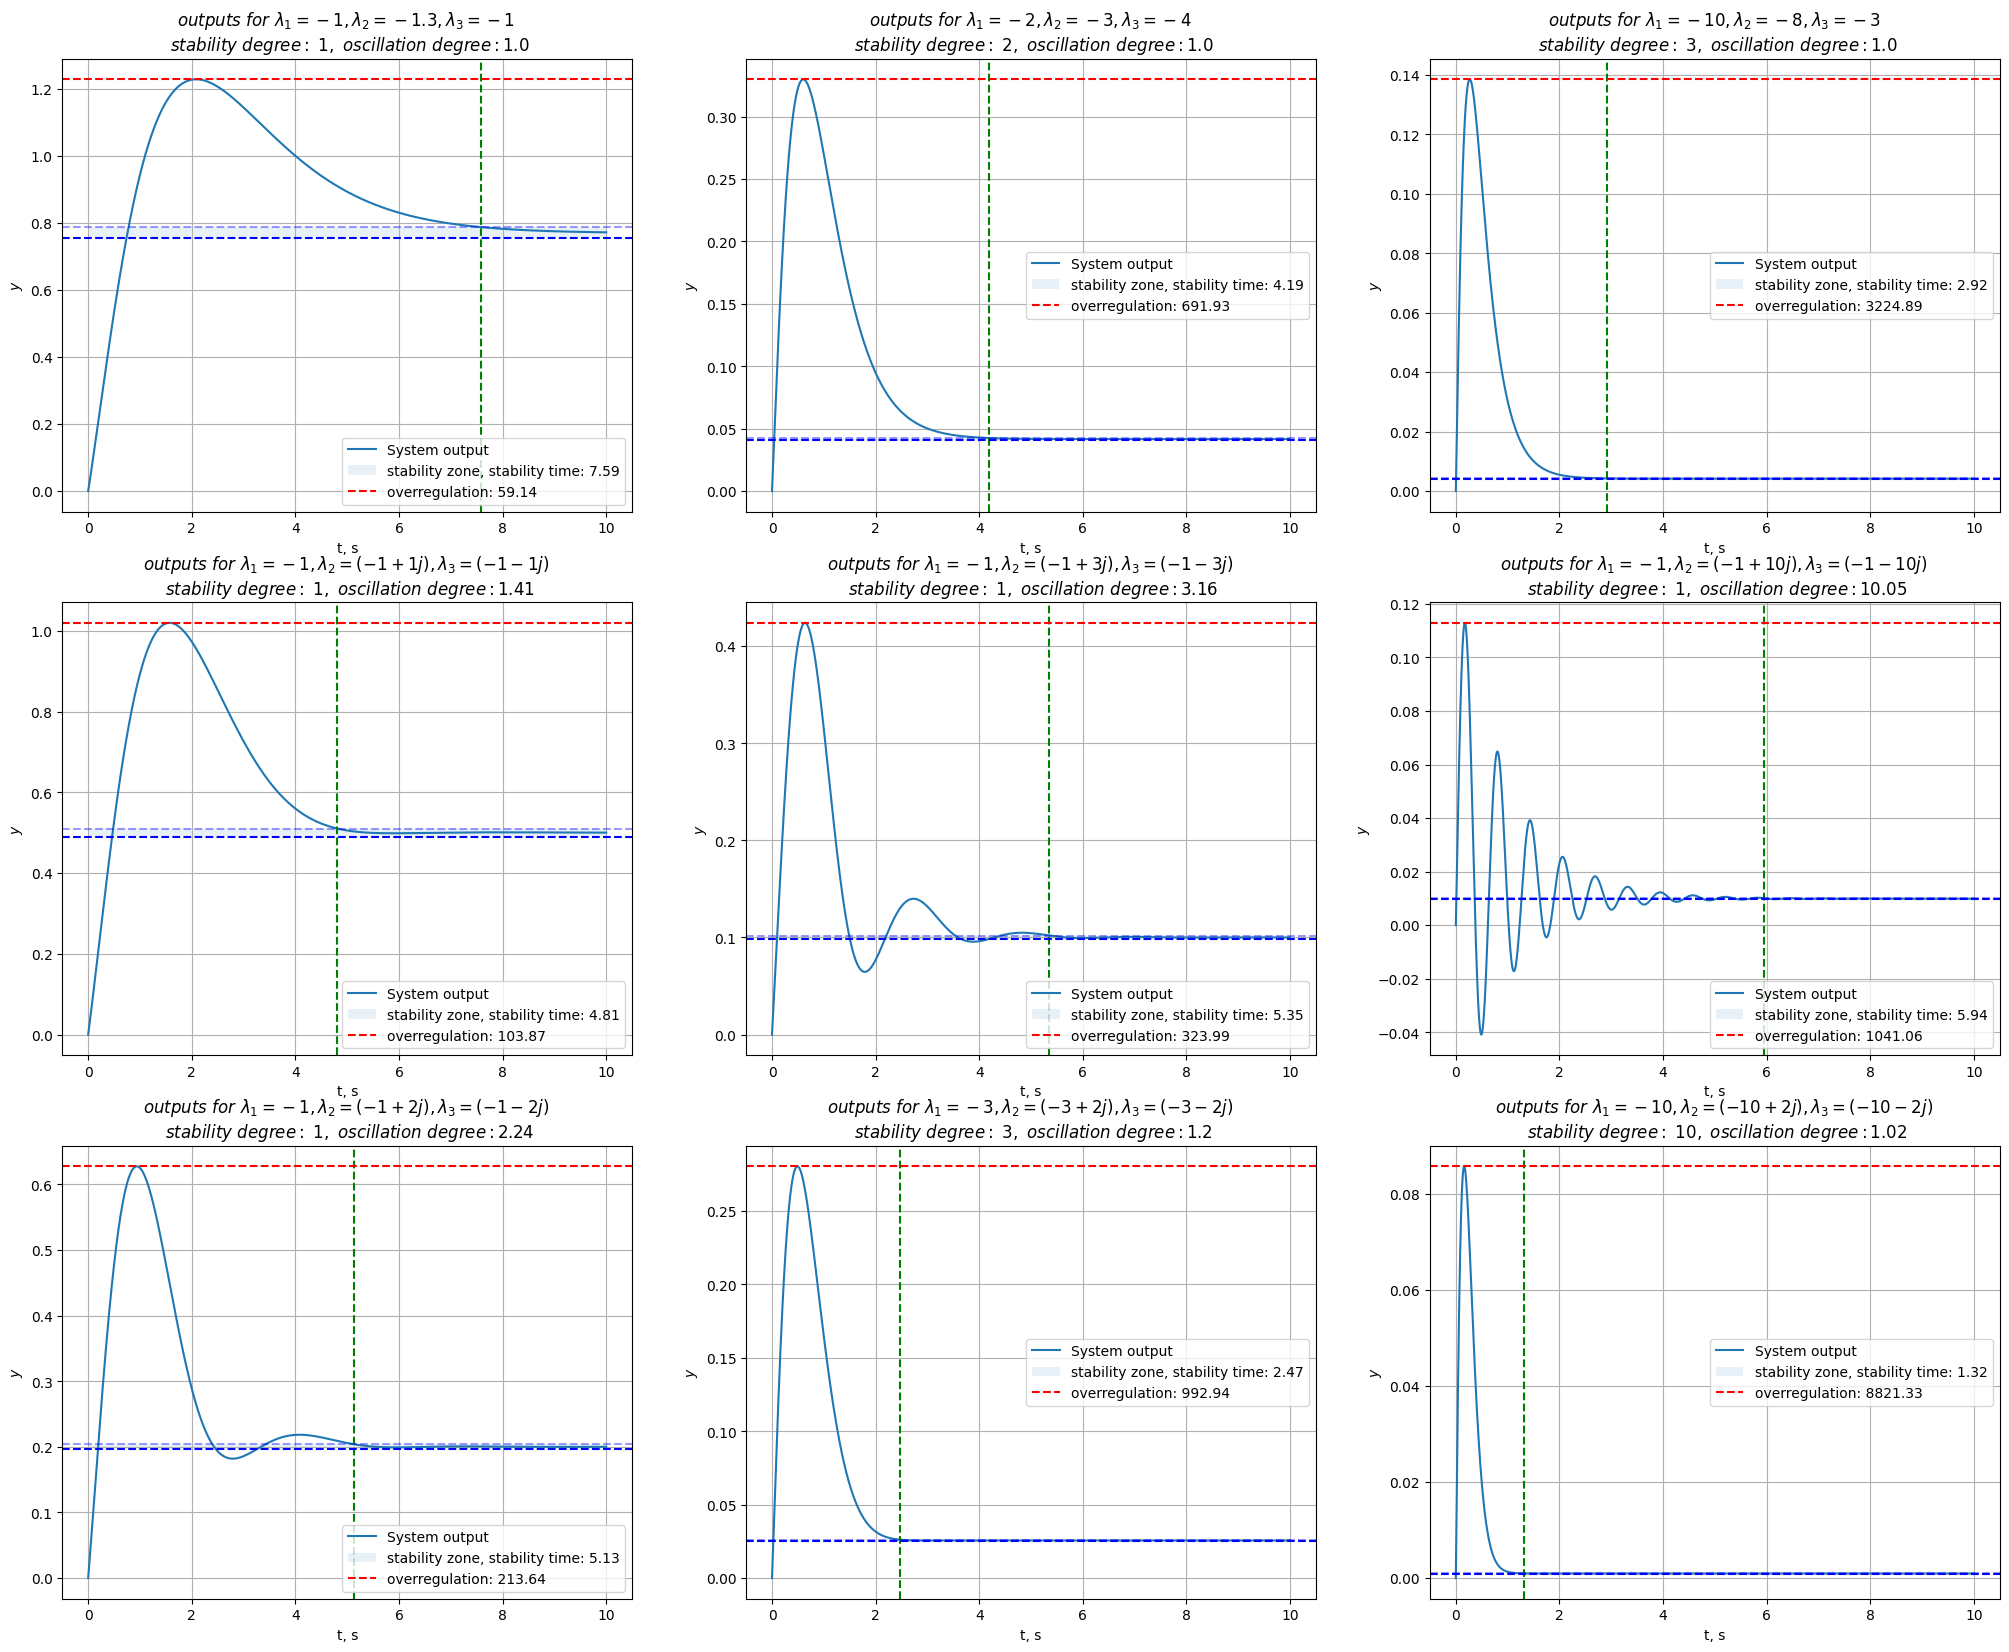

In [21]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(25,20)
)

for i, key in enumerate(systems):
    for j, ss, l in zip(range(3), systems[key], roots[key]):
        y = ct.forced_response(
            ss,
            U=u,
            T=time,
            X0=init_state2
        ).outputs
        
        stability_degree = get_stability_degree(l)
        oscillation_degree = round(get_oscillation_degree(l),2)
        overregulation = round(get_overregulation(y),2)
        stable_time, eps = get_stable_time(y, time)
        
        stable_time = round(stable_time, 2)
        
        title = f"$outputs \ for \ \lambda_1 = {l[0]}, \lambda_2 = {l[1]}, \lambda_3 = {l[2]}$ \n $stability \ degree: \ {stability_degree}, \ oscillation \ degree: {oscillation_degree}$"
        ax[i,j].set_title(title)
        ax[i,j].set_ylabel('$y$')
        ax[i,j].set_xlabel('t, s')
        
        ax[i,j].plot(time, y, label='System output')
        ax[i,j].axvline(x=stable_time, color='g', linestyle='dashed')
        
        ax[i,j].axhline(y=y[-1]+eps, color='b', alpha=0.4, linestyle='dashed')
        ax[i,j].axhline(y=y[-1]-eps, color='b', linestyle='dashed')
        ax[i,j].fill_between(x=time, y1=y[-1]+eps, y2=y[-1]-eps, alpha=0.1,
                             label=f"stability zone, stability time: {stable_time}")
        
        ax[i,j].axhline(y=y.max(), color='r', linestyle='dashed', label=f'overregulation: {overregulation}')
        
        ax[i,j].grid(True)
        ax[i,j].legend()
        

# Задание 3

$u(t)$ = $2sin(t)-cos(t)$

In [22]:
t = sympy.Symbol("t")
W = 6 / (s + 2)**4
coeffs = sympy.Poly(sympy.fraction(W.expand())[1],s).coeffs()

sympy.fraction(W.expand())[1]

s**4 + 8*s**3 + 24*s**2 + 32*s + 16

In [23]:
W = W.expand()

In [24]:
ss = ct.tf2ss(
    [6.],
    [1., 8., 24., 32., 16.]
)

In [25]:
ss

StateSpace(array([[ -8., -24., -32., -16.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.]]), array([[1.],
       [0.],
       [0.],
       [0.]]), array([[0., 0., 0., 6.]]), array([[0.]]))

In [26]:
sec = 10
time = np.linspace(0, sec, int(sec/dt))
u3 = 2*np.sin(time)-np.cos(time)
W_tf = ct.ss2tf(ss)

In [27]:
y_to_conv = sympy.lambdify(t, sympy.inverse_laplace_transform(W,s,t), "numpy")
y_conv = np.convolve(y_to_conv(time), u3)

In [28]:
u = 2*sympy.sin(t) - sympy.cos(t)
U = sympy.laplace_transform(u, t, s)[0]

In [29]:
U = U.simplify()
num =  list(map(float, sympy.Poly(sympy.fraction(U)[0],s).all_coeffs()))
den =  list(map(float, sympy.Poly(sympy.fraction(U)[1],s).all_coeffs()))
U_tf = ct.tf(num, den)
tf3 = W_tf*U_tf

In [30]:
y_model = ct.forced_response(
    W_tf,
    U=u3,
    T=time,
    X0=0
).outputs

y_im = ct.impulse_response(
    tf3, 
    T=time,
    X0=0
).outputs

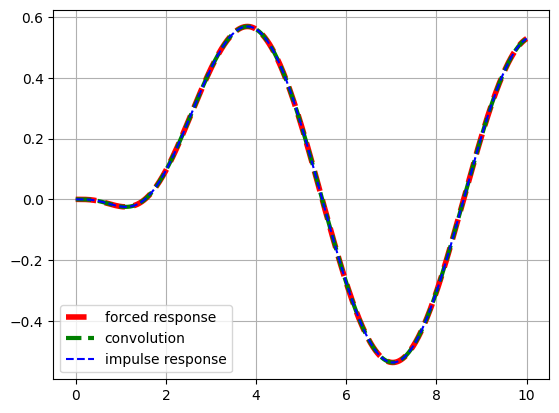

In [31]:
plt.plot(time, y_model, "r--", linewidth=4, label="forced response")
plt.plot(time, y_conv[0:len(time)]*dt, "g--", linewidth=3, label="convolution")
plt.plot(time, y_im, "b--", label="impulse response")
plt.grid()
plt.legend()
